# Convolutional Autoencoder 卷积自编码器

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

使用MNIST数据集，让我们使用卷积层来提高自动编码器的性能。 再次，加载模块和数据。

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


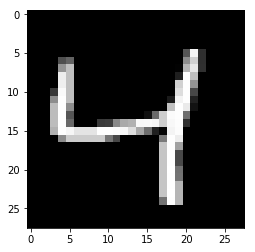

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture 网络架构

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

网络的编码器部分将是典型的卷积金字塔。 每个卷积层后面都会有一个最大池层，以减小层的尺寸。 解码器可能对您而言是新鲜事物。 解码器需要从窄表示转换为宽重建图像。 例如，该表示可以是4×4×8的最大池层。 这是编码器的输出，也是解码器的输入。 我们想从解码器中获取一个28x28x1的图像，所以我们需要从窄的解码器输入层中恢复出来。 网络原理图如下所示。

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

这里我们的最终编码器层的大小为4x4x8 = 128.原始图像的大小为28x28 = 784，因此编码矢量大约为原始图像的大小的16％。 这些只是每个图层的建议尺寸。 随意更改深度和大小，但请记住，我们的目标是找到输入数据的小表示。

### What's going on with the decoder 解码器发生了什么

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find with the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

好的，所以解码器有这些你可能以前看不到的“Upsample”层。 首先，我会讨论一下这些层 *aren't* 。 通常，您将看到**deconvolutional**层用于增加图层的宽度和高度。 它们与卷积层几乎完全相同，但却相反。 在输入层中的步幅在解卷积层中产生更大的步幅。 例如，如果您有3x3内核，输入层中的3x3补丁将在卷积层中减少到一个单位。 相比之下，输入层中的一个单元将在解卷积层中扩展到3x3路径。 解卷积通常被称为“转置卷积”，这是您可以使用TensorFlow API找到的，[`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose)。

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

然而，解卷积层可能导致最终图像中的伪像，例如棋盘图案。 这是由于内核中的重叠，可以通过将步长和内核大小设置为相等来避免。 在这篇文章中，来自Augustus Odena，*等人的[这篇文章](http://distill.pub/2016/deconv-checkerboard/)中，作者表明，通过使用最近邻或双线性调整图层可以避免这些棋盘工件 内插（上采样），然后是卷积层。 在TensorFlow中，这很容易用[`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images)完成，然后是卷积。 请务必阅读Distill文章，以更好地了解解卷积层，以及为什么我们使用上采样。

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

> **练习：**构建上面显示的网络。 记住，具有1和“相同”填充的步长的卷积层不会降低高度和宽度。 也就是说，如果输入是28×28，并且卷积层具有步幅= 1和'相同'填充，则卷积层也将是28×28。 使用最大池层减少宽度和高度。 2的大小将减小大小2. Odena *等人*声称最近邻插值对于上采样最有效，因此请确保将其作为参数在`tf.image.resize_images'中使用或使用[`tf.image.resize_nearest_neighbor`](https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor)。

In [4]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name="input")
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name="targets")

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding="same", activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding="same")
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding="same", activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding="same")
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding="same", activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding="same")
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding="same", activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 =  tf.layers.conv2d(upsample2, 8, (3,3), padding="same", activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding="same", activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding="same", activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name="decoded")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

print("done")

done


## Training 训练

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

像以前一样，这里将会训练网络。 我们可以将它们作为28x28x1阵列传递，而不是使图像平坦化。

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7018
Epoch: 1/20... Training loss: 0.6965
Epoch: 1/20... Training loss: 0.6921
Epoch: 1/20... Training loss: 0.6888
Epoch: 1/20... Training loss: 0.6860
Epoch: 1/20... Training loss: 0.6832
Epoch: 1/20... Training loss: 0.6815
Epoch: 1/20... Training loss: 0.6768
Epoch: 1/20... Training loss: 0.6725
Epoch: 1/20... Training loss: 0.6687
Epoch: 1/20... Training loss: 0.6635
Epoch: 1/20... Training loss: 0.6558
Epoch: 1/20... Training loss: 0.6481
Epoch: 1/20... Training loss: 0.6376
Epoch: 1/20... Training loss: 0.6263
Epoch: 1/20... Training loss: 0.6092
Epoch: 1/20... Training loss: 0.5955
Epoch: 1/20... Training loss: 0.5766
Epoch: 1/20... Training loss: 0.5662
Epoch: 1/20... Training loss: 0.5409
Epoch: 1/20... Training loss: 0.5299
Epoch: 1/20... Training loss: 0.5240
Epoch: 1/20... Training loss: 0.5373
Epoch: 1/20... Training loss: 0.5732
Epoch: 1/20... Training loss: 0.5454
Epoch: 1/20... Training loss: 0.5505
Epoch: 1/20... Training loss: 0.5481
E

Epoch: 1/20... Training loss: 0.1646
Epoch: 1/20... Training loss: 0.1638
Epoch: 1/20... Training loss: 0.1713
Epoch: 1/20... Training loss: 0.1670
Epoch: 1/20... Training loss: 0.1657
Epoch: 1/20... Training loss: 0.1659
Epoch: 1/20... Training loss: 0.1633
Epoch: 1/20... Training loss: 0.1670
Epoch: 1/20... Training loss: 0.1651
Epoch: 1/20... Training loss: 0.1674
Epoch: 1/20... Training loss: 0.1673
Epoch: 1/20... Training loss: 0.1608
Epoch: 1/20... Training loss: 0.1573
Epoch: 1/20... Training loss: 0.1652
Epoch: 1/20... Training loss: 0.1658
Epoch: 1/20... Training loss: 0.1586
Epoch: 1/20... Training loss: 0.1582
Epoch: 1/20... Training loss: 0.1612
Epoch: 1/20... Training loss: 0.1634
Epoch: 1/20... Training loss: 0.1656
Epoch: 1/20... Training loss: 0.1558
Epoch: 1/20... Training loss: 0.1697
Epoch: 1/20... Training loss: 0.1616
Epoch: 1/20... Training loss: 0.1667
Epoch: 1/20... Training loss: 0.1668
Epoch: 1/20... Training loss: 0.1588
Epoch: 1/20... Training loss: 0.1548
E

Epoch: 2/20... Training loss: 0.1420
Epoch: 2/20... Training loss: 0.1386
Epoch: 2/20... Training loss: 0.1345
Epoch: 2/20... Training loss: 0.1404
Epoch: 2/20... Training loss: 0.1341
Epoch: 2/20... Training loss: 0.1353
Epoch: 2/20... Training loss: 0.1429
Epoch: 2/20... Training loss: 0.1386
Epoch: 2/20... Training loss: 0.1349
Epoch: 2/20... Training loss: 0.1400
Epoch: 2/20... Training loss: 0.1426
Epoch: 2/20... Training loss: 0.1395
Epoch: 2/20... Training loss: 0.1372
Epoch: 2/20... Training loss: 0.1426
Epoch: 2/20... Training loss: 0.1349
Epoch: 2/20... Training loss: 0.1345
Epoch: 2/20... Training loss: 0.1412
Epoch: 2/20... Training loss: 0.1346
Epoch: 2/20... Training loss: 0.1396
Epoch: 2/20... Training loss: 0.1432
Epoch: 2/20... Training loss: 0.1392
Epoch: 2/20... Training loss: 0.1330
Epoch: 2/20... Training loss: 0.1378
Epoch: 2/20... Training loss: 0.1382
Epoch: 2/20... Training loss: 0.1343
Epoch: 2/20... Training loss: 0.1367
Epoch: 2/20... Training loss: 0.1399
E

Epoch: 3/20... Training loss: 0.1260
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1256
Epoch: 3/20... Training loss: 0.1327
Epoch: 3/20... Training loss: 0.1203
Epoch: 3/20... Training loss: 0.1228
Epoch: 3/20... Training loss: 0.1246
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1286
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1274
Epoch: 3/20... Training loss: 0.1298
Epoch: 3/20... Training loss: 0.1250
Epoch: 3/20... Training loss: 0.1225
Epoch: 3/20... Training loss: 0.1258
Epoch: 3/20... Training loss: 0.1267
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1289
Epoch: 3/20... Training loss: 0.1262
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1260
Epoch: 3/20... Training loss: 0.1260
Epoch: 3/20... Training loss: 0.1291
Epoch: 3/20... Training loss: 0.1236
Epoch: 3/20... Training loss: 0.1282
Epoch: 3/20... Training loss: 0.1255
Epoch: 3/20... Training loss: 0.1262
E

Epoch: 3/20... Training loss: 0.1206
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1184
Epoch: 3/20... Training loss: 0.1206
Epoch: 3/20... Training loss: 0.1247
Epoch: 3/20... Training loss: 0.1185
Epoch: 3/20... Training loss: 0.1192
Epoch: 3/20... Training loss: 0.1205
Epoch: 3/20... Training loss: 0.1188
Epoch: 3/20... Training loss: 0.1238
Epoch: 4/20... Training loss: 0.1274
Epoch: 4/20... Training loss: 0.1219
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1214
Epoch: 4/20... Training loss: 0.1203
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1236
Epoch: 4/20... Training loss: 0.1170
Epoch: 4/20... Training loss: 0.1199
Epoch: 4/20... Training loss: 0.1223
Epoch: 4/20... Training loss: 0.1226
Epoch: 4/20... Training loss: 0.1230
Epoch: 4/20... Training loss: 0.1197
Epoch: 4/20... Training loss: 0.1212
Epoch: 4/20... Training loss: 0.1214
Epoch: 4/20... Training loss: 0.1184
Epoch: 4/20... Training loss: 0.1199
E

Epoch: 4/20... Training loss: 0.1182
Epoch: 4/20... Training loss: 0.1179
Epoch: 4/20... Training loss: 0.1159
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1187
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1189
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1237
Epoch: 4/20... Training loss: 0.1208
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1124
Epoch: 4/20... Training loss: 0.1222
Epoch: 4/20... Training loss: 0.1181
Epoch: 4/20... Training loss: 0.1116
Epoch: 4/20... Training loss: 0.1158
Epoch: 4/20... Training loss: 0.1202
Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1121
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1162
Epoch: 4/20... Training loss: 0.1170
Epoch: 4/20... Training loss: 0.1150
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1215
Epoch: 4/20... Training loss: 0.1166
E

Epoch: 5/20... Training loss: 0.1095
Epoch: 5/20... Training loss: 0.1125
Epoch: 5/20... Training loss: 0.1105
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1166
Epoch: 5/20... Training loss: 0.1120
Epoch: 5/20... Training loss: 0.1134
Epoch: 5/20... Training loss: 0.1130
Epoch: 5/20... Training loss: 0.1098
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1107
Epoch: 5/20... Training loss: 0.1134
Epoch: 5/20... Training loss: 0.1131
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1107
Epoch: 5/20... Training loss: 0.1139
Epoch: 5/20... Training loss: 0.1131
Epoch: 5/20... Training loss: 0.1151
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1086
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1125
Epoch: 5/20... Training loss: 0.1149
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1129
E

Epoch: 6/20... Training loss: 0.1124
Epoch: 6/20... Training loss: 0.1106
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1128
Epoch: 6/20... Training loss: 0.1097
Epoch: 6/20... Training loss: 0.1124
Epoch: 6/20... Training loss: 0.1104
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1140
Epoch: 6/20... Training loss: 0.1103
Epoch: 6/20... Training loss: 0.1110
Epoch: 6/20... Training loss: 0.1138
Epoch: 6/20... Training loss: 0.1154
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1126
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1050
Epoch: 6/20... Training loss: 0.1080
Epoch: 6/20... Training loss: 0.1094
Epoch: 6/20... Training loss: 0.1113
Epoch: 6/20... Training loss: 0.1094
Epoch: 6/20... Training loss: 0.1094
Epoch: 6/20... Training loss: 0.1116
Epoch: 6/20... Training loss: 0.1090
E

Epoch: 6/20... Training loss: 0.1083
Epoch: 6/20... Training loss: 0.1083
Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1079
Epoch: 6/20... Training loss: 0.1045
Epoch: 6/20... Training loss: 0.1106
Epoch: 6/20... Training loss: 0.1098
Epoch: 6/20... Training loss: 0.1097
Epoch: 6/20... Training loss: 0.1108
Epoch: 6/20... Training loss: 0.1041
Epoch: 6/20... Training loss: 0.1113
Epoch: 6/20... Training loss: 0.1099
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1098
Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1088
Epoch: 6/20... Training loss: 0.1071
Epoch: 7/20... Training loss: 0.1101
Epoch: 7/20... Training loss: 0.1083
Epoch: 7/20... Training loss: 0.1087
Epoch: 7/20... Training loss: 0.1083
Epoch: 7/20... Training loss: 0.1097
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1115
Epoch: 7/20... Training loss: 0.1078
E

Epoch: 7/20... Training loss: 0.1092
Epoch: 7/20... Training loss: 0.1070
Epoch: 7/20... Training loss: 0.1078
Epoch: 7/20... Training loss: 0.1075
Epoch: 7/20... Training loss: 0.1047
Epoch: 7/20... Training loss: 0.1090
Epoch: 7/20... Training loss: 0.1136
Epoch: 7/20... Training loss: 0.1070
Epoch: 7/20... Training loss: 0.1090
Epoch: 7/20... Training loss: 0.1086
Epoch: 7/20... Training loss: 0.1110
Epoch: 7/20... Training loss: 0.1092
Epoch: 7/20... Training loss: 0.1079
Epoch: 7/20... Training loss: 0.1089
Epoch: 7/20... Training loss: 0.1021
Epoch: 7/20... Training loss: 0.1093
Epoch: 7/20... Training loss: 0.1051
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1080
Epoch: 7/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1042
Epoch: 7/20... Training loss: 0.1081
Epoch: 7/20... Training loss: 0.1062
Epoch: 7/20... Training loss: 0.1075
Epoch: 7/20... Training loss: 0.1081
Epoch: 7/20... Training loss: 0.1059
Epoch: 7/20... Training loss: 0.1083
E

Epoch: 8/20... Training loss: 0.1081
Epoch: 8/20... Training loss: 0.1072
Epoch: 8/20... Training loss: 0.1121
Epoch: 8/20... Training loss: 0.1012
Epoch: 8/20... Training loss: 0.1104
Epoch: 8/20... Training loss: 0.1086
Epoch: 8/20... Training loss: 0.1078
Epoch: 8/20... Training loss: 0.1100
Epoch: 8/20... Training loss: 0.1086
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1047
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1075
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1070
Epoch: 8/20... Training loss: 0.1032
Epoch: 8/20... Training loss: 0.1035
Epoch: 8/20... Training loss: 0.1004
Epoch: 8/20... Training loss: 0.1056
Epoch: 8/20... Training loss: 0.1095
Epoch: 8/20... Training loss: 0.1025
Epoch: 8/20... Training loss: 0.1089
Epoch: 8/20... Training loss: 0.1045
Epoch: 8/20... Training loss: 0.1092
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1037
Epoch: 8/20... Training loss: 0.1032
E

Epoch: 9/20... Training loss: 0.1034
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1039
Epoch: 9/20... Training loss: 0.1049
Epoch: 9/20... Training loss: 0.1031
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1034
Epoch: 9/20... Training loss: 0.1044
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1067
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.1068
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1074
Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1046
Epoch: 9/20... Training loss: 0.1046
Epoch: 9/20... Training loss: 0.1025
Epoch: 9/20... Training loss: 0.1007
Epoch: 9/20... Training loss: 0.1031
Epoch: 9/20... Training loss: 0.1059
Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1046
Epoch: 9/20... Training loss: 0.1059
Epoch: 9/20... Training loss: 0.1038
Epoch: 9/20... Training loss: 0.1059
Epoch: 9/20... Training loss: 0.1006
E

Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1040
Epoch: 9/20... Training loss: 0.1031
Epoch: 9/20... Training loss: 0.0995
Epoch: 9/20... Training loss: 0.1034
Epoch: 9/20... Training loss: 0.1075
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1038
Epoch: 9/20... Training loss: 0.1067
Epoch: 9/20... Training loss: 0.1019
Epoch: 9/20... Training loss: 0.1038
Epoch: 9/20... Training loss: 0.1068
Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.1063
Epoch: 9/20... Training loss: 0.1032
Epoch: 9/20... Training loss: 0.1012
Epoch: 9/20... Training loss: 0.1056
Epoch: 9/20... Training loss: 0.1044
Epoch: 9/20... Training loss: 0.1044
Epoch: 9/20... Training loss: 0.1047
Epoch: 9/20... Training loss: 0.1036
Epoch: 9/20... Training loss: 0.0998
Epoch: 9/20... Training loss: 0.1030
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.1065
Epoch: 9/20... Training loss: 0.1016
E

Epoch: 10/20... Training loss: 0.1035
Epoch: 10/20... Training loss: 0.1043
Epoch: 10/20... Training loss: 0.1005
Epoch: 10/20... Training loss: 0.1041
Epoch: 10/20... Training loss: 0.1047
Epoch: 10/20... Training loss: 0.1034
Epoch: 10/20... Training loss: 0.1046
Epoch: 10/20... Training loss: 0.1019
Epoch: 10/20... Training loss: 0.1040
Epoch: 10/20... Training loss: 0.1067
Epoch: 10/20... Training loss: 0.1020
Epoch: 10/20... Training loss: 0.1031
Epoch: 10/20... Training loss: 0.1047
Epoch: 10/20... Training loss: 0.1009
Epoch: 10/20... Training loss: 0.1045
Epoch: 10/20... Training loss: 0.0999
Epoch: 10/20... Training loss: 0.1018
Epoch: 10/20... Training loss: 0.1076
Epoch: 10/20... Training loss: 0.1003
Epoch: 10/20... Training loss: 0.1087
Epoch: 10/20... Training loss: 0.1009
Epoch: 10/20... Training loss: 0.1039
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.1064
Epoch: 10/20... Training loss: 0.1043
Epoch: 10/20... Training loss: 0.1028
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1017
Epoch: 11/20... Training loss: 0.1009
Epoch: 11/20... Training loss: 0.1020
Epoch: 11/20... Training loss: 0.1011
Epoch: 11/20... Training loss: 0.0984
Epoch: 11/20... Training loss: 0.1005
Epoch: 11/20... Training loss: 0.1011
Epoch: 11/20... Training loss: 0.1036
Epoch: 11/20... Training loss: 0.1045
Epoch: 11/20... Training loss: 0.1010
Epoch: 11/20... Training loss: 0.1036
Epoch: 11/20... Training loss: 0.1001
Epoch: 11/20... Training loss: 0.1017
Epoch: 11/20... Training loss: 0.1038
Epoch: 11/20... Training loss: 0.1010
Epoch: 11/20... Training loss: 0.1000
Epoch: 11/20... Training loss: 0.0998
Epoch: 11/20... Training loss: 0.1021
Epoch: 11/20... Training loss: 0.1018
Epoch: 11/20... Training loss: 0.1009
Epoch: 11/20... Training loss: 0.1052
Epoch: 11/20... Training loss: 0.1021
Epoch: 11/20... Training loss: 0.0985
Epoch: 11/20... Training loss: 0.1003
Epoch: 11/20... Training loss: 0.1017
Epoch: 11/20... Training loss: 0.1022
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1024
Epoch: 12/20... Training loss: 0.0949
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20... Training loss: 0.0995
Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.1009
Epoch: 12/20... Training loss: 0.1029
Epoch: 12/20... Training loss: 0.1020
Epoch: 12/20... Training loss: 0.1017
Epoch: 12/20... Training loss: 0.1007
Epoch: 12/20... Training loss: 0.1005
Epoch: 12/20... Training loss: 0.1010
Epoch: 12/20... Training loss: 0.1035
Epoch: 12/20... Training loss: 0.1010
Epoch: 12/20... Training loss: 0.1015
Epoch: 12/20... Training loss: 0.0977
Epoch: 12/20... Training loss: 0.0996
Epoch: 12/20... Training loss: 0.1009
Epoch: 12/20... Training loss: 0.1004
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.1012
Epoch: 12/20... Training loss: 0.0992
Epoch: 12/20... Training loss: 0.1046
Epoch: 12/20... Training loss: 0.1031
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0998
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0986
Epoch: 12/20... Training loss: 0.1017
Epoch: 12/20... Training loss: 0.1007
Epoch: 12/20... Training loss: 0.0996
Epoch: 12/20... Training loss: 0.0992
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0998
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1022
Epoch: 12/20... Training loss: 0.1001
Epoch: 12/20... Training loss: 0.1035
Epoch: 12/20... Training loss: 0.1001
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20... Training loss: 0.0979
Epoch: 12/20... Training loss: 0.0984
Epoch: 12/20... Training loss: 0.0999
Epoch: 12/20... Training loss: 0.1011
Epoch: 12/20... Training loss: 0.1025
Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.1001
Epoch: 12/20... Training loss: 0.1007
Epoch: 12/20... Training loss: 0.1000
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.1027
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0989
Epoch: 13/20... Training loss: 0.0988
Epoch: 13/20... Training loss: 0.1003
Epoch: 13/20... Training loss: 0.0985
Epoch: 13/20... Training loss: 0.0992
Epoch: 13/20... Training loss: 0.1015
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.1003
Epoch: 13/20... Training loss: 0.0983
Epoch: 13/20... Training loss: 0.1001
Epoch: 13/20... Training loss: 0.1004
Epoch: 13/20... Training loss: 0.0968
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.0975
Epoch: 13/20... Training loss: 0.0983
Epoch: 13/20... Training loss: 0.1028
Epoch: 13/20... Training loss: 0.0999
Epoch: 13/20... Training loss: 0.1026
Epoch: 13/20... Training loss: 0.1012
Epoch: 13/20... Training loss: 0.1023
Epoch: 13/20... Training loss: 0.1011
Epoch: 13/20... Training loss: 0.1028
Epoch: 13/20... Training loss: 0.1021
Epoch: 13/20... Training loss: 0.1042
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0992
Epoch: 14/20... Training loss: 0.0994
Epoch: 14/20... Training loss: 0.0985
Epoch: 14/20... Training loss: 0.0985
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.0982
Epoch: 14/20... Training loss: 0.0987
Epoch: 14/20... Training loss: 0.0997
Epoch: 14/20... Training loss: 0.0997
Epoch: 14/20... Training loss: 0.1032
Epoch: 14/20... Training loss: 0.1049
Epoch: 14/20... Training loss: 0.1016
Epoch: 14/20... Training loss: 0.0992
Epoch: 14/20... Training loss: 0.0974
Epoch: 14/20... Training loss: 0.0994
Epoch: 14/20... Training loss: 0.0963
Epoch: 14/20... Training loss: 0.0977
Epoch: 14/20... Training loss: 0.1033
Epoch: 14/20... Training loss: 0.0994
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.0999
Epoch: 14/20... Training loss: 0.0984
Epoch: 14/20... Training loss: 0.0998
Epoch: 14/20... Training loss: 0.0988
Epoch: 14/20... Training loss: 0.1012
Epoch: 14/20... Training loss: 0.0995
Epoch: 14/20

Epoch: 14/20... Training loss: 0.0998
Epoch: 14/20... Training loss: 0.0978
Epoch: 14/20... Training loss: 0.1000
Epoch: 14/20... Training loss: 0.0923
Epoch: 14/20... Training loss: 0.0947
Epoch: 14/20... Training loss: 0.1002
Epoch: 14/20... Training loss: 0.0951
Epoch: 14/20... Training loss: 0.1013
Epoch: 14/20... Training loss: 0.0994
Epoch: 15/20... Training loss: 0.1016
Epoch: 15/20... Training loss: 0.1007
Epoch: 15/20... Training loss: 0.1022
Epoch: 15/20... Training loss: 0.0981
Epoch: 15/20... Training loss: 0.0980
Epoch: 15/20... Training loss: 0.0948
Epoch: 15/20... Training loss: 0.1010
Epoch: 15/20... Training loss: 0.0952
Epoch: 15/20... Training loss: 0.1017
Epoch: 15/20... Training loss: 0.0997
Epoch: 15/20... Training loss: 0.1008
Epoch: 15/20... Training loss: 0.1007
Epoch: 15/20... Training loss: 0.0972
Epoch: 15/20... Training loss: 0.0972
Epoch: 15/20... Training loss: 0.1017
Epoch: 15/20... Training loss: 0.1004
Epoch: 15/20... Training loss: 0.1009
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0949
Epoch: 15/20... Training loss: 0.0956
Epoch: 15/20... Training loss: 0.0990
Epoch: 15/20... Training loss: 0.1006
Epoch: 15/20... Training loss: 0.0974
Epoch: 15/20... Training loss: 0.0972
Epoch: 15/20... Training loss: 0.0986
Epoch: 15/20... Training loss: 0.0984
Epoch: 15/20... Training loss: 0.0982
Epoch: 15/20... Training loss: 0.0982
Epoch: 15/20... Training loss: 0.1000
Epoch: 15/20... Training loss: 0.0978
Epoch: 15/20... Training loss: 0.0989
Epoch: 15/20... Training loss: 0.0979
Epoch: 15/20... Training loss: 0.0994
Epoch: 15/20... Training loss: 0.0997
Epoch: 15/20... Training loss: 0.0934
Epoch: 15/20... Training loss: 0.1009
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.1019
Epoch: 15/20... Training loss: 0.0971
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0982
Epoch: 15/20... Training loss: 0.0980
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0998
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.1036
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.0958
Epoch: 16/20... Training loss: 0.1007
Epoch: 16/20... Training loss: 0.0989
Epoch: 16/20... Training loss: 0.0989
Epoch: 16/20... Training loss: 0.1004
Epoch: 16/20... Training loss: 0.0972
Epoch: 16/20... Training loss: 0.0980
Epoch: 16/20... Training loss: 0.0995
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.0988
Epoch: 16/20... Training loss: 0.0995
Epoch: 16/20... Training loss: 0.0982
Epoch: 16/20... Training loss: 0.0948
Epoch: 16/20... Training loss: 0.1020
Epoch: 16/20... Training loss: 0.0964
Epoch: 16/20... Training loss: 0.1004
Epoch: 16/20... Training loss: 0.0969
Epoch: 16/20... Training loss: 0.0972
Epoch: 16/20... Training loss: 0.1002
Epoch: 16/20... Training loss: 0.0998
Epoch: 16/20... Training loss: 0.0999
Epoch: 16/20... Training loss: 0.0978
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1016
Epoch: 17/20... Training loss: 0.0967
Epoch: 17/20... Training loss: 0.1020
Epoch: 17/20... Training loss: 0.0977
Epoch: 17/20... Training loss: 0.0980
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.0993
Epoch: 17/20... Training loss: 0.0961
Epoch: 17/20... Training loss: 0.0949
Epoch: 17/20... Training loss: 0.0989
Epoch: 17/20... Training loss: 0.0959
Epoch: 17/20... Training loss: 0.0964
Epoch: 17/20... Training loss: 0.1012
Epoch: 17/20... Training loss: 0.0977
Epoch: 17/20... Training loss: 0.1015
Epoch: 17/20... Training loss: 0.0993
Epoch: 17/20... Training loss: 0.0985
Epoch: 17/20... Training loss: 0.0994
Epoch: 17/20... Training loss: 0.0964
Epoch: 17/20... Training loss: 0.0984
Epoch: 17/20... Training loss: 0.1011
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.0984
Epoch: 17/20... Training loss: 0.1017
Epoch: 17/20... Training loss: 0.0961
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0940
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20... Training loss: 0.0960
Epoch: 17/20... Training loss: 0.1009
Epoch: 17/20... Training loss: 0.0995
Epoch: 17/20... Training loss: 0.0976
Epoch: 17/20... Training loss: 0.0999
Epoch: 17/20... Training loss: 0.0977
Epoch: 17/20... Training loss: 0.0949
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.0962
Epoch: 17/20... Training loss: 0.0965
Epoch: 17/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0990
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.1012
Epoch: 17/20... Training loss: 0.0969
Epoch: 17/20... Training loss: 0.1039
Epoch: 17/20... Training loss: 0.0985
Epoch: 17/20... Training loss: 0.0986
Epoch: 17/20... Training loss: 0.0982
Epoch: 17/20... Training loss: 0.1003
Epoch: 17/20... Training loss: 0.0962
Epoch: 17/20... Training loss: 0.1012
Epoch: 17/20... Training loss: 0.0979
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0995
Epoch: 18/20... Training loss: 0.0973
Epoch: 18/20... Training loss: 0.0965
Epoch: 18/20... Training loss: 0.0956
Epoch: 18/20... Training loss: 0.0953
Epoch: 18/20... Training loss: 0.0930
Epoch: 18/20... Training loss: 0.0955
Epoch: 18/20... Training loss: 0.0958
Epoch: 18/20... Training loss: 0.0929
Epoch: 18/20... Training loss: 0.0978
Epoch: 18/20... Training loss: 0.0969
Epoch: 18/20... Training loss: 0.0992
Epoch: 18/20... Training loss: 0.0958
Epoch: 18/20... Training loss: 0.0991
Epoch: 18/20... Training loss: 0.0974
Epoch: 18/20... Training loss: 0.0957
Epoch: 18/20... Training loss: 0.0961
Epoch: 18/20... Training loss: 0.0987
Epoch: 18/20... Training loss: 0.0996
Epoch: 18/20... Training loss: 0.0952
Epoch: 18/20... Training loss: 0.0965
Epoch: 18/20... Training loss: 0.0960
Epoch: 18/20... Training loss: 0.0982
Epoch: 18/20... Training loss: 0.1010
Epoch: 18/20... Training loss: 0.0984
Epoch: 18/20... Training loss: 0.0980
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0941
Epoch: 19/20... Training loss: 0.0971
Epoch: 19/20... Training loss: 0.0979
Epoch: 19/20... Training loss: 0.0995
Epoch: 19/20... Training loss: 0.0971
Epoch: 19/20... Training loss: 0.0988
Epoch: 19/20... Training loss: 0.0998
Epoch: 19/20... Training loss: 0.0993
Epoch: 19/20... Training loss: 0.1002
Epoch: 19/20... Training loss: 0.0990
Epoch: 19/20... Training loss: 0.0971
Epoch: 19/20... Training loss: 0.0962
Epoch: 19/20... Training loss: 0.0954
Epoch: 19/20... Training loss: 0.0977
Epoch: 19/20... Training loss: 0.0991
Epoch: 19/20... Training loss: 0.1019
Epoch: 19/20... Training loss: 0.0958
Epoch: 19/20... Training loss: 0.0928
Epoch: 19/20... Training loss: 0.0961
Epoch: 19/20... Training loss: 0.0993
Epoch: 19/20... Training loss: 0.0964
Epoch: 19/20... Training loss: 0.0957
Epoch: 19/20... Training loss: 0.0995
Epoch: 19/20... Training loss: 0.0996
Epoch: 19/20... Training loss: 0.0951
Epoch: 19/20... Training loss: 0.0952
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0990
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0935
Epoch: 20/20... Training loss: 0.0970
Epoch: 20/20... Training loss: 0.0960
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20... Training loss: 0.0992
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0971
Epoch: 20/20... Training loss: 0.0991
Epoch: 20/20... Training loss: 0.0970
Epoch: 20/20... Training loss: 0.0989
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0964
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0987
Epoch: 20/20... Training loss: 0.0949
Epoch: 20/20... Training loss: 0.0964
Epoch: 20/20... Training loss: 0.0994
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0952
Epoch: 20/20... Training loss: 0.0946
Epoch: 20/20... Training loss: 0.0960
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0966
Epoch: 20/20... Training loss: 0.0942
Epoch: 20/20... Training loss: 0.1007
Epoch: 20/20... Training loss: 0.1016
Epoch: 20/20... Training loss: 0.0988
Epoch: 20/20... Training loss: 0.0959
Epoch: 20/20... Training loss: 0.0966
Epoch: 20/20... Training loss: 0.0974
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.0958
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20... Training loss: 0.0980
Epoch: 20/20... Training loss: 0.1002
Epoch: 20/20... Training loss: 0.0907
Epoch: 20/20... Training loss: 0.0991
Epoch: 20/20... Training loss: 0.0989
Epoch: 20/20... Training loss: 0.0947
Epoch: 20/20... Training loss: 0.0989
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0988
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0968
Epoch: 20/20... Training loss: 0.0943
Epoch: 20/20... Training loss: 0.0950
Epoch: 20/20... Training loss: 0.0952
Epoch: 20/20

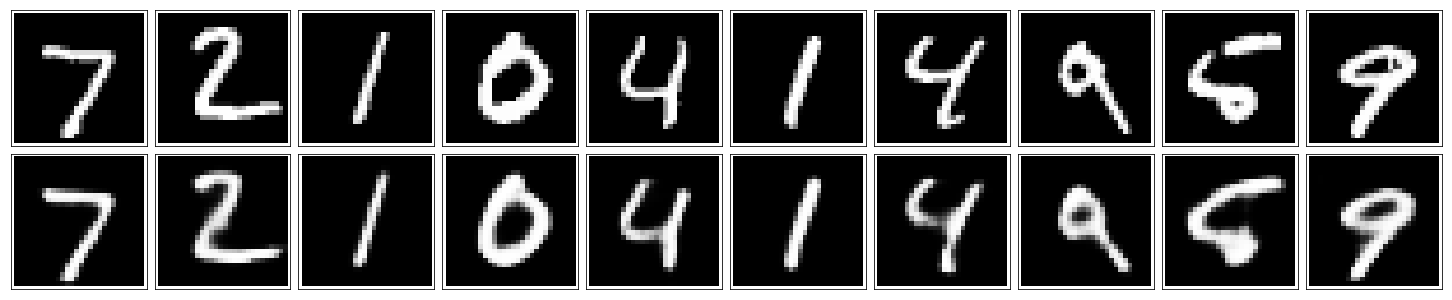

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

## Denoising 去噪

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

如前所述，自动编码器如你所建造的那样，在实践中并不太有用。 然而，它们可以用于通过在嘈杂的图像上训练网络来非常成功地去噪图像。 我们可以通过将高斯噪声添加到训练图像中，然后将值剪切在0和1之间来创建嘈杂的图像。我们将使用嘈杂的图像作为输入，将原始的干净图像作为目标。 以下是我生成的嘈杂图像和去噪图像的示例。

![Denoising autoencoder](assets/denoising.png)

Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

由于这对于网络来说是一个更难的问题，所以我们需要在这里使用更深的卷积层，更多的功能图。 对于编码器中卷积层的深度，我建议像32-32-16这样的深度，并且通过解码器向后的相同深度。 否则，架构与以前相同。

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

> **练习：**构建去噪自动编码器的网络。 与以前相同，但层次更深。 我建议32-32-16的深度，但你可以玩这些数字，或添加更多的图层。

In [9]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding="same", activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding="same")
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding="same", activation=tf.nn.relu)
# Now conv2
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding="same")
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding="same", activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding="same")
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding="same", activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding="same", activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding="same", activation=tf.nn.relu)
# Now 28x28x32

logits =  tf.layers.conv2d(conv6, 1, (3,3), padding="same", activation=tf.nn.relu)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =  tf.nn.sigmoid(logits, name='output')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

print("done")

done


In [10]:
sess = tf.Session()

In [12]:
epochs = 20
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6948
Epoch: 1/20... Training loss: 0.6932
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
E

Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
Epoch: 1/20... Training loss: 0.6931
E

Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
Epoch: 2/20... Training loss: 0.6931
E

Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
E

Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 3/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
E

Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
Epoch: 4/20... Training loss: 0.6931
E

Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
Epoch: 5/20... Training loss: 0.6931
E

Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
E

Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 6/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
E

Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
Epoch: 7/20... Training loss: 0.6931
E

Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
Epoch: 8/20... Training loss: 0.6931
E

Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
E

Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
Epoch: 9/20... Training loss: 0.6931
E

Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20... Training loss: 0.6931
Epoch: 10/20

Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20... Training loss: 0.6931
Epoch: 11/20

Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20

Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20... Training loss: 0.6931
Epoch: 12/20

Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20... Training loss: 0.6931
Epoch: 13/20

Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20... Training loss: 0.6931
Epoch: 14/20

Epoch: 14/20... Training loss: 0.6931


KeyboardInterrupt: 

## Checking out the performance 检查性能

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

在这里，我添加了噪音到测试图像并传递他们通过自动编码器。 尽管有时难以判断原始号码是什么，但它除了噪音外，还是一个非常好的工作。

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)